In [33]:
import matplotlib.pyplot as plt
from itertools import accumulate
from scipy.stats import norm
from statistics import mean,variance
from math import sqrt,log,inf,exp
import csv
import time
from sortedcontainers import SortedList as OST

In [2]:
def split(f,g,R) :
    ra,rb = min(R),max(R)
    return min([(r,f(ra,r) + g(r,rb)) for r in R],key = lambda x : x[1])
    

In [3]:
def amoc(g,R,beta) :
    def f(i,j) : return 0 if i == j else g(i,j-1) + beta
    return split(f,g,R)
    

In [4]:
def op(g,R,beta,prune=False) :
    class functor :
        def __init__(self) :
            self.D = {}
        def add(self,x,y) :
            self.D[x] = y
        def __call__(self,*arg) :
            _,x = arg
            return self.D[x]
    f = functor()
    ra = min(R)
    T = []
    segmentation = {}
    cost = -beta
    for r in R :
        f.add(r,cost + beta)
        T.append(r)
        if prune :
            T = [t for t in T if f(ra,t) + g(t,r) <= f(ra,r) + beta]
        index,cost = split(f,g,T)
        segmentation[r] = (index,cost)
    return segmentation
    

In [5]:
def pelt(g,R,beta) :
    return op(g,R,beta,True)

In [6]:
def changepoints(segmentations) :
    ra = min(segmentations)
    rb = max(segmentations)
    index = rb
    locations = []
    while index != ra :
        index,_ = segmentations[index]
        locations.append(index)
    return locations

In [7]:
class sumstats :
    def __init__(self,X) :
        self.X = X
        self.SX = [0] + list(accumulate(X))
        self.SXX = [0] + list(accumulate([x*x for x in X]))

In [8]:
class normal_mean :
    def __init__(self,X) :
        self.sumstats = sumstats(X)
    def __call__(self,i,j) :
        val = self.sumstats.SX[j+1] - self.sumstats.SX[i]
        val *= val
        val /= (j - i + 1)
        val = -val
        val += self.sumstats.SXX[j+1] - self.sumstats.SXX[i]
        return val

In [195]:
X = [0.0 for i in range(1000)] + [1.0 for i in range(1000)] 
E = norm.rvs(size=len(X))
Z = [x+e for x,e in zip(X,E)]
#mu = mean(Z)
#sigma = sqrt(variance(Z))
#Z = [(z-mu)/sigma for z in Z]
#plt.plot(Z)
#plt.show()

In [10]:
g = normal_mean(Z)
amoc(g,list(range(len(Z))),2*log(len(Z)))

(1000, 1601.5214029745525)

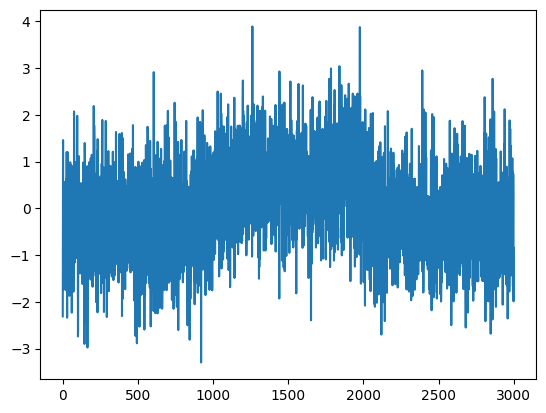

In [11]:
X = [0.0 for i in range(1000)] + [1.0 for i in range(1000)] + [0.0 for i in range(1000)]
E = norm.rvs(size=len(X))
Z = [x+e for x,e in zip(X,E)]
mu = mean(Z)
sigma = sqrt(variance(Z))
Z = [(z-mu)/sigma for z in Z]
plt.plot(Z)
plt.show()

In [12]:
g = normal_mean(Z)
start =  time.perf_counter()
res = op(g,list(range(len(Z))),2*log(len(Z)))
end =  time.perf_counter()
print(changepoints(res))
print(end-start)

[2001, 996, 0]
3.415971000213176


In [13]:
g = normal_mean(Z)
start =  time.perf_counter()
res = pelt(g,list(range(len(Z))),2*log(len(Z)))
end =  time.perf_counter()
print(changepoints(res))
print(end-start)

[2001, 996, 0]
2.721504464978352


In [68]:
file = open("X.csv", "r")
X = list(csv.reader(file, delimiter=","))
X = [float(item) for sublist in X for item in sublist]
file.close()
print(mean(X),sqrt(variance(X)))

-3.9863529867114243e-17 1.0


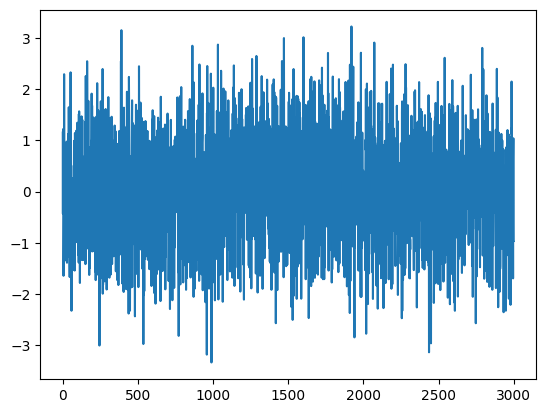

In [15]:
plt.plot(X)
plt.show()

In [16]:
g = normal_mean(X)
start =  time.perf_counter()
res = op(g,list(range(len(X))),2*log(len(X)))
end =  time.perf_counter()
print(changepoints(res))
print(end - start)

[1933, 1025, 0]
2.8561626009177417


In [17]:
g = normal_mean(X)
start =  time.perf_counter()
res = pelt(g,list(range(len(X))),2*log(len(X)))
end =  time.perf_counter()
print(changepoints(res))
print(end - start)

[1933, 1025, 0]
4.567221871111542


In [18]:
import numpy as np

import matplotlib.pyplot as plt

from scipy import stats

rng = np.random.default_rng()

In [19]:
X1 = list(range(200))
E1 = norm.rvs(size=len(X1))
a1 = 1.6
b1 = 2
Y1 = [a1*x + b1 + e for x,e in zip(X1,E1)]
X2 = [x + len(X1) for x in X1]
E2 = norm.rvs(size=len(X2))
a2 = 1.0
b2 = (a1-a2)*X1[-1] + b1 
Y2 = [a2*x + b2 + e for x,e in zip(X2,E2)]
X = X1 + X2
Y = Y1 + Y2


In [20]:
res = stats.linregress(X, Y)
Y_hat = [res.slope*x + res.intercept for x in X]

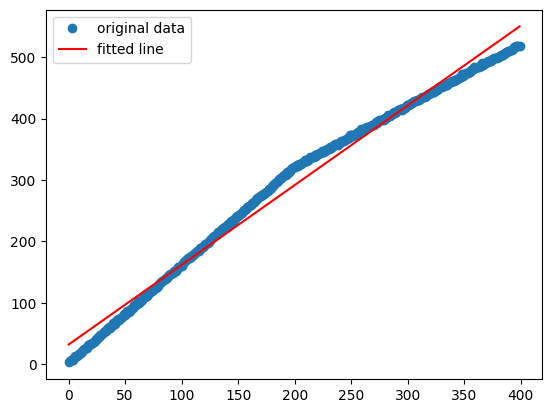

In [21]:
plt.plot(X, Y, 'o', label='original data')

plt.plot(X, Y_hat, 'r', label='fitted line')

plt.legend()

plt.show()

In [22]:
res

LinregressResult(slope=1.2989379955833804, intercept=31.846230245158438, rvalue=0.9933403397426972, pvalue=0.0, stderr=0.0075520625262702964, intercept_stderr=1.7408036527128457)

In [23]:
class linear :
    def __init__(self,X,Y) :
        self.X = X
        self.Y = Y
    def __call__(self,i,j) :
        if i ==j :
            return inf
        regression = stats.linregress(self.X[i:(j+1)],self.Y[i:(j+1)])
        a = regression.slope
        b = regression.intercept
        return sum([(y - a*x - b)*(y - a*x - b) for x,y in zip(self.X[i:(j+1)],self.Y[i:(j+1)])])

In [24]:
g = linear(X,Y)
start =  time.perf_counter()
res = op(g,list(range(len(X))),2*log(len(X)))
end =  time.perf_counter()
print(changepoints(res))
print(end - start)

[378, 356, 203, 202, 0]
8.220623875036836


In [191]:
class eCDFfh :
    def __init__(self,X,k) :
        def quantiles(T,k) :
            # this function computes k quantiles in data from a window of size n
            # the expression for the probabilities is taken from Zou (2014) and 
            # Haynes (2017) and is designed to add emphasis to the tails of the 
            # probability distribution. Both authors show doing so increases power.
            # data is the data to use for computing the quantiles
            # k is the number of quantiles and n is the window size
            n = len(T)
            def quantile(prob) :
                #this function works out the quantile value
                #it uses linear interpolation, ie quantile type = 7
                h = (n - 1) * prob
                h_floor = int(h)
                if h_floor == h:
                    return T[h]
                else:
                    non_int_part = h - h_floor 
                    lower = T[h_floor]
                    upper = T[h_floor + 1]
                    return lower + non_int_part * (upper - lower)
            c = log(2*n-1)   # weight as in Zou (2014)
            probs = [(1/(1+(2*(n-1)*exp((-c/k)*(2*i-1))))) for i in range(k)]
            return [quantile(p) for p in probs]    
        
        def eCDF(T,Q):    
            # used to return value of eCDF, not cost, at a given quantile  
            # data is the tree of data used to compute the ecdf
            # quantile is the numeric quantile value
            vals = []
            for q in Q :
                left = T.bisect_left(q)
                right = T.bisect_right(q)
                # value is number of points to left of quantile, plus 0.5 times
                # the points equal to the quantile
                vals.append((left+0.5*(right-left))/len(T))
            return vals
        
        def cost(cdf_vals,w):
            #function for computing the likelihood function
            #cdf_val is the value of the eCDF at a set quantile
            #seg_len is the length of the data used
            val = 0.0
            for cdf_val in cdf_vals : 
                if(cdf_val > 0 and cdf_val < 1):
                    conj = 1 - cdf_val
                    val += w * (cdf_val * log(cdf_val) - conj * log(conj))
            return(val)
        
        
        self.n = len(X)
        self.X = X
        self.T = OST(X)
        self.k = k
        # determine quantiles
        self.Q = quantiles(self.T,self.k)
        # determine eCDF
        self.L = {}
        for j in range(self.n) :
            self.T = OST(self.X[:(j+1)])
            for i in range(j+1) :
                self.L[(i,j)] = cost(eCDF(self.T,self.Q),self.n)
                self.T.remove(self.X[i])
                
    def __call__(self,i,j) :
        return self.L[(i,j)]
        
        
        

In [196]:
g = eCDFfh(Z,8)

In [189]:
R = list(range(len(Z)))
res = op(g,R,64*log(len(Z)))

In [190]:
res[1999]

(1995, -184.9680997275845)

In [180]:
changepoints(res)

KeyboardInterrupt: 

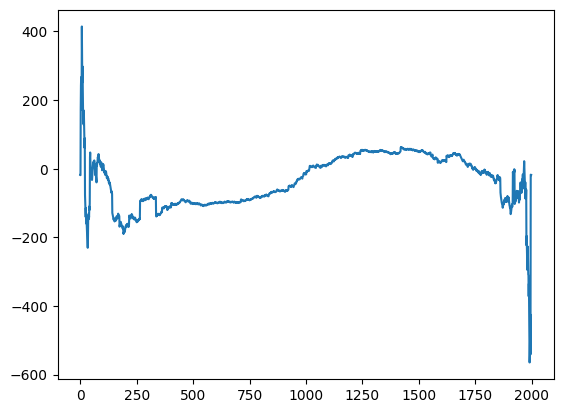

In [197]:

cost = [g(0,i) + g(i+1,1999) for i in range(len(Z)-1)]
plt.plot(cost)
    

In [160]:
2*log(len(X))

15.201804919084164

In [166]:
print(g(0,1999),min(cost))


18.4176633926834 -2.385781198510511
